# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install requirements

In [2]:
%pip install pytorch_lightning

     |████████████████████████████████| 527 kB 30.9 MB/s 
     |████████████████████████████████| 134 kB 68.2 MB/s 
     |████████████████████████████████| 397 kB 65.4 MB/s 
     |████████████████████████████████| 829 kB 57.3 MB/s 
     |████████████████████████████████| 952 kB 38.4 MB/s 
     |████████████████████████████████| 596 kB 26.9 MB/s 
     |████████████████████████████████| 1.1 MB 69.8 MB/s 
     |████████████████████████████████| 144 kB 71.2 MB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4a99cd8c950a43dfa109accdfbcecd3d1558a6d041577f922462fef4ab06520d
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

In [3]:
%pip install timm

     |████████████████████████████████| 431 kB 23.2 MB/s 


# Import relevant libraries

In [4]:
import sys
import os
module_path = os.path.join(os.path.abspath(''), "drive/MyDrive/Master_Thesis_Profactor/zdmp/")
if module_path not in sys.path:
  sys.path.append(module_path)

import zdmp
from utils.lightning_classifier import Classifier
from utils.external_utils.vision_transformer import VitGenerator

from utils.external_utils.swin_transformer import SwinGenerator

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader

import timm

# Prepare Dataset and Dataloader

In [5]:
# Make the results reproducible
pl.seed_everything(42)

# Prepare dataset
ds_train = zdmp.get_train_data(vit=True)  # Resize from 300x300px to 224x224px
ds_test = zdmp.get_test_data(vit=True)

# Prepare Dataloaders
dl_train = DataLoader(ds_train, batch_size=16, num_workers=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=16, num_workers=2)

Global seed set to 42


zdmp - ViT size - True
get_data - ViT size - True
transform - ViT size - True


# Select Transformer model

* 0 - ViT
* 1 - Swin-Tiny

In [11]:
model_names = ["vit", "swin_t"]
model_name = model_names[0]           # Select HERE which model to use

# Prepare Model

In [ ]:
# Prepare model
if model_name == "vit":
    model = VitGenerator('vit_small', 
                        8, 
                        'cuda', 
                        evaluate=False, 
                        random=False, 
                        verbose=True,
                        num_classes=2
                        )
elif model_name == "swin_t":
    model = timm.models.swin_tiny_patch4_window7_224(pretrained=True)
    model.head = torch.nn.Linear(768, 2)

[INFO] Initializing vit_small with patch size of 16
[INFO] Loading weights


# Train ViT Model

In [ ]:

def save_model(model, name):
    path = os.path.join(
        "/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights",
        f"{name}.pth.tar"
    )
    torch.save(model.state_dict(), path)

In [ ]:
# Prepare Classifier to train the model
if model_name == "vit":
    classifier = Classifier(model.model)
elif model_name == "swin_t":
    classifier = Classifier(model)
    
# Prepare the Trainer
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=3)

# Train
trainer.fit(classifier, dl_train, dl_test)

# Save the trained weights
#save_model(classifier.model, model_name)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | VisionTransformer | 21.7 M
1 | train_metrics | MetricCollection  | 0     
2 | valid_metrics | MetricCollection  | 0     
----------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
43.333    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

PatchEmbed(
  (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
)

# Tensorboard
For both train and validation:
* Accuracy
* Precission
* Recall
* Loss

In [ ]:
!tensorboard dev upload --logdir '/content/lightning_logs'


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/lightning_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Mh7bNLgH5BCpwPyug4XohlADIF9hJt&prompt=consent&access_type

# Load state dictionary from url

In [49]:
model_name = "swin_t"
timm_model = False

if model_name == "vit":
    state_dict = torch.hub.load_state_dict_from_url("https://drive.google.com/uc?export=download&id=1-7kjESSsw5wKtHUnNx8C1q2lpPbL45jj&confirm=t")
    if timm_model:
        #model = timm.models.vit_small_patch16_224()
        #model = timm.models.vit_small_patch8_224_dino()
        print(model)
        model.head = torch.nn.Linear(384, 2)
        model.load_state_dict(state_dict)
    else:
        model = VitGenerator('vit_small', 
                        8, 
                        'cuda', 
                        evaluate=False, 
                        random=True, 
                        verbose=True,
                        num_classes=2
                        )
        #model.model.load_state_dict(state_dict)
        model.model.load_state_dict(torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/vit.pth.tar"))

elif model_name == "swin_t":
    state_dict = torch.hub.load_state_dict_from_url("https://drive.google.com/uc?export=download&id=1ttiqssbh-nyjCSFQxhsRvG0S66SkrBs6&confirm=t")
    if timm_model:
        model = timm.models.swin_tiny_patch4_window7_224()
        model.head = torch.nn.Linear(768, 2)
        model.load_state_dict(state_dict)
    else:
        model = SwinGenerator('cuda', random=True, verbose=True, num_classes=2)
        model.model.load_state_dict(state_dict)
    

[INFO] Initializing swin_base_patch4_window7_224


# Test trained model

In [ ]:
wrong = 0
for i, (img, lbl) in enumerate(ds_test):
    out = int(model(img.unsqueeze(0)).softmax(1).argmax())
    if out != lbl:
        wrong+=1
    print(f"{i}\tPred: {out}\tTrue:{lbl}\t{'' if out==lbl else '*'*5}")
print(f"Wrong: {wrong}/{len(ds_test)}")

0	Pred: 1	True:1	
1	Pred: 1	True:1	
2	Pred: 1	True:1	
3	Pred: 1	True:1	
4	Pred: 0	True:0	
5	Pred: 0	True:0	
6	Pred: 0	True:0	
7	Pred: 0	True:0	
8	Pred: 1	True:1	
9	Pred: 0	True:0	
10	Pred: 0	True:0	
11	Pred: 1	True:1	
12	Pred: 0	True:0	
13	Pred: 0	True:0	
14	Pred: 1	True:1	
15	Pred: 1	True:1	
16	Pred: 0	True:0	
17	Pred: 0	True:0	
18	Pred: 1	True:1	
19	Pred: 1	True:1	
20	Pred: 1	True:1	
21	Pred: 0	True:0	
22	Pred: 0	True:0	
23	Pred: 1	True:1	
24	Pred: 0	True:0	
25	Pred: 1	True:1	
26	Pred: 0	True:0	
27	Pred: 0	True:0	
28	Pred: 0	True:0	
29	Pred: 0	True:0	
30	Pred: 1	True:1	
31	Pred: 0	True:0	
32	Pred: 1	True:1	
33	Pred: 0	True:0	
34	Pred: 0	True:0	
35	Pred: 0	True:0	
36	Pred: 0	True:0	
37	Pred: 0	True:0	
38	Pred: 0	True:0	
39	Pred: 0	True:0	
40	Pred: 1	True:1	
41	Pred: 1	True:1	
42	Pred: 1	True:1	
43	Pred: 0	True:0	
44	Pred: 0	True:0	
45	Pred: 1	True:1	
46	Pred: 0	True:0	
47	Pred: 1	True:1	
48	Pred: 1	True:1	
49	Pred: 0	True:0	
50	Pred: 0	True:0	
51	Pred: 0	True:0	
52	Pred: 0	True:0	
53	

# Visualize Attention

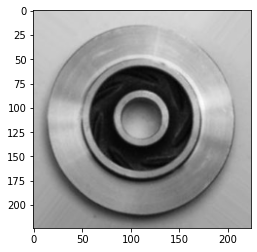

In [ ]:
import matplotlib.pyplot as plt

img, lbl = ds_test[87]

mean = torch.tensor([0.3460, 0.4832, 0.7033])
std = torch.tensor([1.0419, 1.0652, 1.0605])

plt.imshow(((img
                  * std[:, None, None] 
                  + mean[:, None, None])).permute(1, 2, 0).numpy())
plt.show()

# ViT Attention

tensor(0) 0
24 56 56 torch.Size([1, 24, 49, 49])
24 56 56 torch.Size([1, 24, 49, 49])
(24, 49, 49)
(224, 224)
57624


TypeError: ignored

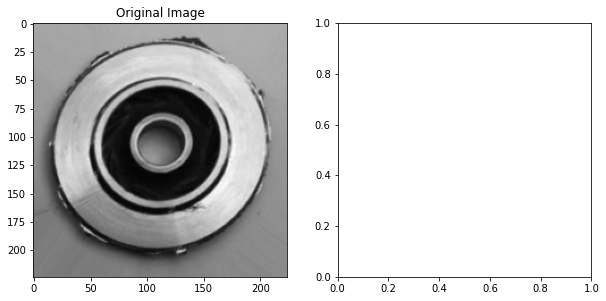

In [74]:
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from utils.external_utils.preprocess import visualize_predict

img, lbl = ds_test[50]

mean = torch.tensor([0.3460, 0.4832, 0.7033]) 
std = torch.tensor([1.0419, 1.0652, 1.0605])


def transform_(img, img_size):
	img = transforms.Resize(img_size)(img)
	img = transforms.ToTensor()(img)
	return img

def to_PIL(img):
  trans = transforms.ToPILImage()
  return trans(img * std[:, None, None] + mean[:, None, None])

factor_reduce = 1
img_size = 224
model.model.to('cpu')
print(model(img.unsqueeze(0)).softmax(dim=0).argmax(), lbl)
model.model.to('cuda')
with torch.no_grad():
    visualize_predict2(model, to_PIL(img), img_size, 4, 'cuda')

In [73]:
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img

def visualize_predict2(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device) 
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1] # number of head

    print(nh, w_featmap, h_featmap, attentions.shape)
    
    # keep only the output patch attention
    #attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    
    print(nh, w_featmap, h_featmap, attentions.shape)

    #attentions = attentions.reshape(nh, w_featmap, h_featmap)
    #attentions = torch.nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    print(torch.mean(attentions, 0, True).squeeze(0).cpu().numpy().shape)
    return torch.mean(attentions, 0, True).cpu().numpy()

def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10,10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        print(fig.size)
        im = plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
        if i == 1:
            #plt.colorbar()
            plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()
	
    plt.figure(figsize=(10,10))    
    for i in range(n_heads):
        plt.subplot(n_heads//3,3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()